In this machine learning project, the MNIST dataset served as the foundation for an image classification task. The dataset was enriched by applying data augmentation techniques, such as shifting pixel values within each image.

A well-structured pipeline was established to ensure efficient data preprocessing and model optimization. Standard scaling was employed as part of data preprocessing to standardize and normalize the features, ensuring that the model could perform optimally.

The KNeighborsClassifier / K-Nearest Neighbors (KNN) classifier was chosen as the classification model, offering an intuitive approach to the problem. The key challenge lay in finding the best hyperparameters for the KNN model to achieve peak performance. To tackle this, GridSearchCV, a powerful hyperparameter tuning tool, was employed. It systematically explored various combinations of hyperparameters to identify the optimal settings for the KNN classifier.

**Training Scores**:

Accuracy scores: [0.98052851 0.96870654 0.96314325 0.97494781 0.98051496]
Precision scores: [0.98071818 0.96922823 0.96343154 0.97508987 0.98064474]
Recall scores: [0.98052851 0.96870654 0.96314325 0.97494781 0.98051496]
F1 scores: [0.98054214 0.96862043 0.96293557 0.97481804 0.9804537]
Furthermore, the model's performance has been evaluated on the holdout set:

**Prediction Scores on Holdout Set**:

Accuracy on holdout set: 0.9816360601001669
Precision on holdout set: 0.9817826685295102
Recall on holdout set: 0.9816360601001669
F1 score on holdout set: 0.9815563633379836

In [2]:
# Load the dataset
from sklearn.datasets import load_digits

digits = load_digits()

In [3]:
# Understand the data
print('digits shape:', digits.data.shape)
print('target:', digits.target)
print('image shape:', digits.images.shape)

digits shape: (1797, 64)
target: [0 1 2 ... 8 9 8]
image shape: (1797, 8, 8)


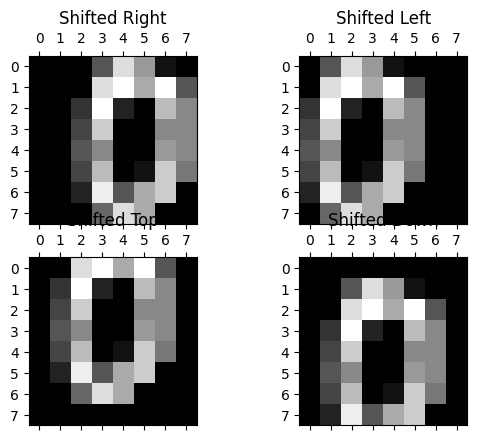

In [4]:
# Shift the image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import shift

label = digits.target[0]
firstImage = digits.data[0]
rawImage = digits.images[0]

reshapedImage = firstImage.reshape(8,8)
shifted_right = shift(reshapedImage, shift=(0, 1))
shifted_left = shift(reshapedImage, shift=(0, -1))
shifted_top = shift(reshapedImage, shift=(-1, 0))
shifted_down = shift(reshapedImage, shift=(1, 0))

fig, axs = plt.subplots(2, 2)
cmap = 'gray'

# Plot the shifted images
axs[0, 0].set_title('Shifted Right')
axs[0, 0].matshow(shifted_right, cmap=cmap)

axs[0, 1].set_title('Shifted Left')
axs[0, 1].matshow(shifted_left, cmap=cmap)

axs[1, 0].set_title('Shifted Top')
axs[1, 0].matshow(shifted_top, cmap=cmap)

axs[1, 1].set_title('Shifted Down')
axs[1, 1].matshow(shifted_down, cmap=cmap)

plt.show()

In [21]:
# data augmentation
from scipy.ndimage import shift

# Define the shifts
shifts = [(0, 1), (0, -1), (-1, 0), (1, 0)]

# Lists to store the new data and labels
data = []
labels = []

# Iterate through the original data and create shifted images
for image, label in zip(digits.data, digits.target):
    reshaped_image = image.reshape(8, 8)

    # Add the original image
    data.append(image)
    labels.append(label)

    # Create and add the shifted images
    for shift_values in shifts:
        shifted_image = shift(reshaped_image, shift=shift_values)
        data.append(shifted_image.ravel())
        labels.append(label)

# Convert the lists to NumPy arrays
data = np.array(data)
labels = np.array(labels)

print('data shape:', data.shape)
print('label shape:', labels.shape)

data shape: (8985, 64)
label shape: (8985,)


In [6]:
# dataset class description
unique_labels = np.unique(digits.target)

# Count the number of samples for each class
class_counts = {label: np.sum(digits.target == label) for label in unique_labels}

# Print the number of classes and samples for each class
print("Number of classes:", len(unique_labels))
print("Number of samples for each class:")
for label, count in class_counts.items():
    print(f"Class {label}: {count} samples")

Number of classes: 10
Number of samples for each class:
Class 0: 178 samples
Class 1: 182 samples
Class 2: 177 samples
Class 3: 183 samples
Class 4: 181 samples
Class 5: 182 samples
Class 6: 181 samples
Class 7: 179 samples
Class 8: 174 samples
Class 9: 180 samples


In [8]:
# Splitting the dataset
from sklearn.model_selection import StratifiedShuffleSplit

# 80/20 (train/test)
stratified_split = StratifiedShuffleSplit(n_splits=7, train_size=0.8, random_state=42)

for train_index, holdout_index in stratified_split.split(data, labels):
    X_train, X_holdout = data[train_index], data[holdout_index]
    Y_train, Y_holdout = labels[train_index], labels[holdout_index]

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_holdout shape:', X_holdout.shape)
print('Y_holdout shape:', Y_holdout.shape)

X_train shape: (7188, 64)
Y_train shape: (7188,)
X_holdout shape: (1797, 64)
Y_holdout shape: (1797,)


In [20]:
# Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score


grid_parameters = {
    'classifier__n_neighbors': list(range(3, 11)),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__leaf_size': [10, 20, 30, 40],
    'classifier__p': [1, 2]
}

# Scaler
scaler = StandardScaler()

# Classifier
classifier = KNeighborsClassifier()

# Pipeline steps
pipeline_steps = [
    ('scaler', scaler),
    ('classifier', classifier)
]

pipeline = Pipeline(pipeline_steps)

# Validation metric to influence the search
cross_validation = cross_val_score(pipeline, X_train, Y_train, cv=5, scoring='accuracy')

# Model
model = GridSearchCV(estimator=pipeline, param_grid=grid_parameters, cv=5, scoring='accuracy', verbose=2)

# Fit the model
model.fit(X_train, Y_train)

# Scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}
results = cross_validate(pipeline, X_train, Y_train, cv=5, scoring=scoring, return_train_score=True)

accuracy_scores = results['test_accuracy']
precision_scores = results['test_precision']
recall_scores = results['test_recall']
f1_scores = results['test_f1']


print(f'Accuracy scores: {accuracy_scores}')
print(f'Precision scores: {precision_scores}')
print(f'Recall scores: {recall_scores}')
print(f'F1 scores: {f1_scores}')

Accuracy scores: [0.98052851 0.96870654 0.96314325 0.97494781 0.98051496]
Precision scores: [0.98071818 0.96922823 0.96343154 0.97508987 0.98064474]
Recall scores: [0.98052851 0.96870654 0.96314325 0.97494781 0.98051496]
F1 scores: [0.98054214 0.96862043 0.96293557 0.97481804 0.9804537 ]


In [17]:
best_hyperparameters = model.best_params_
print("Best Hyperparameters:", best_hyperparameters)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Use the final model to make predictions on the holdout set
holdout_predictions = model.predict(X_holdout)

# Calculate performance metrics
accuracy = accuracy_score(Y_holdout, holdout_predictions)
precision = precision_score(Y_holdout, holdout_predictions, average='weighted')
recall = recall_score(Y_holdout, holdout_predictions, average='weighted')
f1 = f1_score(Y_holdout, holdout_predictions, average='weighted')

# Print the performance metrics
print(f'Accuracy on holdout set: {accuracy}')
print(f'Precision on holdout set: {precision}')
print(f'Recall on holdout set: {recall}')
print(f'F1 score on holdout set: {f1}')


Best Hyperparameters: {'classifier__leaf_size': 10, 'classifier__n_neighbors': 4, 'classifier__p': 1, 'classifier__weights': 'distance'}
Accuracy on holdout set: 0.9816360601001669
Precision on holdout set: 0.9817826685295102
Recall on holdout set: 0.9816360601001669
F1 score on holdout set: 0.9815563633379836
